In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files


# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
train_file_id = "1e8LHzkN9lBfZaW_GfRtS3Ybi3rwkJEJj"
train_file_name = "tokyo.csv"
train_file_id1 = "1ivRYCaGB_Tz9n9BA4OUi_640eNd-44aw"
train_file_name1 = "BloomDates.csv"

downloaded = drive.CreateFile({'id': train_file_id})
downloaded.GetContentFile(train_file_name)

downloaded = drive.CreateFile({'id': train_file_id1})
downloaded.GetContentFile(train_file_name1)

import math
import numpy as np
import pandas as pd
import sklearn.metrics as mc
import sklearn.neural_network
from matplotlib import pyplot as plt
from pandas import DataFrame
import datetime
%matplotlib inline

Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

In [0]:
#tokyo.csv data(English version dataset of the given file tokyo.csv)
data_tokyo_Sakura = pd.read_csv(train_file_name,  error_bad_lines=False, encoding="GBK")
#bloom data
#BloomDates.csv contain blooming dates of Sakura which is collected from apanese Meteorological Agency website
data_BD = pd.read_csv(train_file_name1,  error_bad_lines=False, encoding="GBK")

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

    training years  acc_temp
0             1961     721.0
1             1962     768.1
2             1963     701.7
3             1964     676.6
4             1965     642.2
5             1967     660.8
6             1968     654.6
7             1969     724.0
8             1970     696.3
9             1972     610.4
10            1973     705.3
11            1974     658.0
12            1975     607.9
13            1976     596.7
14            1977     556.7
15            1978     640.1
16            1979     631.8
17            1980     640.6
18            1981     600.1
19            1982     581.5
20            1983     662.5
21            1984     643.7
22            1986     627.5
23            1987     588.7
24            1988     649.7
25            1989     583.1
26            1990     573.6
27            1991     688.2
28            1992     615.5
29            1993     612.9
30            1995     684.6
31            1996     680.1
32            1997     614.6
33            

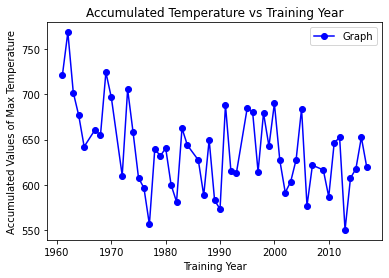

In [0]:
#separate training years

test_years = [1966,1971,1985,1994,2008]
training_years = []
for i in range(1961,2018):
  if i not in test_years:
    training_years = training_years + [i]

training_data = data_tokyo_Sakura
training_BD = data_BD

tested_data = data_tokyo_Sakura
tested_BD = data_BD

#Separating test data from training data
for i in test_years:
  training_data = training_data[training_data.year != i]
  training_BD = training_BD[training_BD.year != i]

for i in training_years:
  tested_data = tested_data[tested_data.year != i]
  tested_BD = tested_BD[tested_BD.year != i]

#creating dataframe with year,month,day,max temp and bloom data

df_tokyo = pd.DataFrame(training_data,columns=['year','month','day','max temp','bloom'])
date = pd.to_datetime(df_tokyo[['year','month','day']])
df_tokyo.insert(0,'date',date)

date = pd.to_datetime(training_BD[['year','month','day']])
training_BD.insert(0,'date',date)

training_BD = training_BD.set_index('date')

#extracting data from Feb_1 to Bloomdate for each training year

acc_temp_df = pd.DataFrame(columns=['max temp'])

for i in range(len(training_years)):
  y = training_years[i]
  start_date = str(y) + '-02-01'
  end_date = training_BD[training_BD['year']== y ].index.values
  end_date = ''.join(str(e) for e in end_date)
  end_date = end_date[0:10]
  mask = (df_tokyo['date'] >= start_date) & (df_tokyo['date'] <= end_date)

  df = df_tokyo.loc[mask]
  df = pd.DataFrame(df,columns=['max temp']).cumsum(skipna=True)
  #df_max_temp = df.cumsum(skipna=True)
  #accumulated_max_temp.append(df_max_temp.tail(1))
  #accumulated_max_temp.append(df.tail(1))
  acc_temp_df = acc_temp_df.append(df.tail(1))

acc_temp_df.reset_index(inplace = True)
acc_temp_df =  acc_temp_df.drop(['index'],axis = 1)
train_yrs_df = pd.DataFrame(training_years,columns=['training years'])

#Output_Frame
train_yrs_df["acc_temp"] = acc_temp_df
print(train_yrs_df)

T_mean =  train_yrs_df["acc_temp"].mean() 
print("Temp_mean = " ,T_mean)
if(T_mean == 600):
  print("600 degree Celsius rule can be applied for Tokyo")
else:
  print("600 degree Celsius rule can not be applied for Tokyo")

acc_value = acc_temp_df.values.tolist()

#Graph_Plot
plt.figure(1)
plt.plot(training_years,acc_value,'-bo',label="Graph")
plt.xlabel('Training Year')
plt.ylabel('Accumulated Values of Max Temperature')
plt.title("Accumulated Temperature vs Training Year")
plt.legend()
plt.show()

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

Actual Bloom Dates
    year  month  day
5   1966      3   20
10  1971      3   30
24  1985      4    3
33  1994      3   31
47  2008      3   22
-----------600c prediction-----------
       year  month  day
1904   1966      3   20
3737   1971      3   27
8853   1985      3   29
12139  1994      3   28
17248  2008      3   23
-----------Tmean prediction-----------
       year  month  day
1907   1966      3   23
3739   1971      3   29
8856   1985      4    1
12142  1994      3   31
17250  2008      3   25
-----------Error for 600c Rule-----------
   year  error
0  1966      0
1  1971      3
2  1985     26
3  1994      3
4  2008      1
-----------Error for Tmean Rule-----------
   year  error
0  1966      3
1  1971      1
2  1985      2
3  1994      0
4  2008      3
Accuracy_600 : 0.2
Accuracy_Tmean : 0.2
R2 Score for Tmean Rule : 0.832
R2 Score for 600 Rule : 0.679


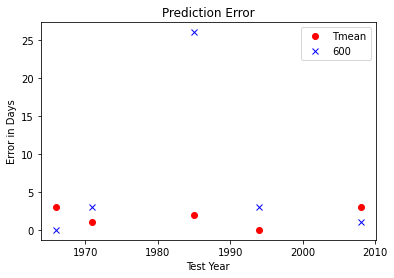

In [0]:
#taking dataframe of tested_data only including date,max temp 
tested_data_df = pd.DataFrame(tested_data,columns=['year','month','day','max temp'])

#creating date from year,month and day
date = pd.to_datetime(tested_data_df[['year','month','day']])
tested_data_df.insert(0,'date',date)

df0 = pd.DataFrame()
df0 = tested_data_df

#prediction using 600c
pred_600_df = pd.DataFrame()
for i in range(len(test_years)):
  y = test_years[i]
  df1 = df0.query("year == " + str(y) + "& month > 1")
  val = pd.Index(df1['max temp'].cumsum()).get_loc(600, 'backfill')  
  pred_600_df = pred_600_df.append(df1.iloc[val])

pred_600_df = pd.DataFrame(pred_600_df,columns = ['year','month','day']).astype('int64')

print("Actual Bloom Dates")
print(tested_BD)

#prediction using 600c
print("-----------600c prediction-----------")
print(pred_600_df)

#prediction using Tmean
Tmean = 638.36
pred_Tmean_df = pd.DataFrame()
for i in range(len(test_years)):
  y = test_years[i]
  df1 = df0.query("year == " + str(y) + "& month > 1")
  val = pd.Index(df1['max temp'].cumsum()).get_loc(Tmean, 'backfill')  
  pred_Tmean_df = pred_Tmean_df.append(df1.iloc[val])
pred_Tmean_df = pd.DataFrame(pred_Tmean_df,columns = ['year','month','day']).astype('int64')
print("-----------Tmean prediction-----------")
print(pred_Tmean_df)

#ERROR for 600 Rule
er600_df = pd.DataFrame()
d1 = tested_BD.day
d1 = d1.reset_index(drop=True)
d2 = pred_600_df.day
d2 = d2.reset_index(drop=True)
tested_BD = tested_BD.reset_index(drop=True)
er600_df['year'] = tested_BD['year']
er600_df['error'] = abs(d1-d2)
print("-----------Error for 600c Rule-----------")
print(er600_df)

#ERROR for Tmean Rule
erTmean_df = pd.DataFrame()
d1 = tested_BD.day
d1 = d1.reset_index(drop=True)
d2 = pred_Tmean_df.day
d2 = d2.reset_index(drop=True)
tested_BD = tested_BD.reset_index(drop=True)
erTmean_df['year'] = tested_BD['year']
erTmean_df['error'] = abs(d1-d2)
print("-----------Error for Tmean Rule-----------")
print(erTmean_df)

#Accuracy for 600 Rule
acc_600 = er600_df['error'].values.tolist()
acc_600 = acc_600.count(0)
print("Accuracy_600 :",acc_600/5)

#Accuracy for Tmean Rule
acc_Tmean = erTmean_df['error'].values.tolist()
acc_Tmean = acc_Tmean.count(0)
print("Accuracy_Tmean :",acc_Tmean/5)

#R2 for Tmean Rule
PreDaysTmean=[]  # Predicted difference from January 1 
Actual_Days=[]  # Actual difference in days from January 1 

for i in range(5):
    d1 = datetime.date(tested_BD.values[i][0],tested_BD.values[i][1],tested_BD.values[i][2])
    d2 = datetime.date(pred_Tmean_df.values[i][0],pred_Tmean_df.values[i][1],pred_Tmean_df.values[i][2])
    d3 = datetime.date(tested_BD.values[i][0],1,1)
    da = abs(d1-d3).days+1
    dp = abs(d2-d3).days+1
    Actual_Days = Actual_Days + [da]
    PreDaysTmean = PreDaysTmean+[dp]   
R2Tmean = mc.r2_score(Actual_Days,PreDaysTmean) #Builtin function of SK learn

R2Tmean=float("{:.3f}".format(R2Tmean))
print("R2 Score for Tmean Rule :",R2Tmean)

#R2 for 600 Rule
PreDays600=[]  # Predicted difference from January 1 
for i in range(5):
    d1=datetime.date(pred_600_df.values[i][0],pred_600_df.values[i][1],pred_600_df.values[i][2])
    d2=datetime.date(tested_BD.values[i][0],1,1)
    dp=abs(d1-d2).days+1
    PreDays600=PreDays600+[dp]
#using SKlearn
R2600=mc.r2_score(Actual_Days,PreDays600)
R2600=float("{:.3f}".format(R2600))
print("R2 Score for 600 Rule :",R2600)

#Plotting
errT = erTmean_df['error'].values.tolist()
err600 = er600_df['error'].values.tolist()

plt.figure(2)
plt.plot(test_years,errT,"ro",label="Tmean")
plt.plot(test_years,err600,"bx",label="600")
plt.xlabel('Test Year')
plt.ylabel('Error in Days')
plt.title("Prediction Error")
plt.legend()
plt.show()

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)


     All Years  Dj
0        1961  39
1        1962  42
2        1963  38
3        1964  40
4        1965  39
5        1966  45
6        1967  42
7        1968  44
8        1969  43
9        1970  39
10       1971  43
11       1972  46
12       1973  45
13       1974  40
14       1975  41
15       1976  45
16       1977  41
17       1978  42
18       1979  51
19       1980  42
20       1981  42
21       1982  45
22       1983  45
23       1984  36
24       1985  41
25       1986  39
26       1987  46
27       1988  45
28       1989  51
29       1990  48
30       1991  47
31       1992  48
32       1993  47
33       1994  44
34       1995  46
35       1996  45
36       1997  50
37       1998  47
38       1999  49
39       2000  48
40       2001  45
41       2002  56
42       2003  44
43       2004  50
44       2005  45
45       2006  46
46       2007  55
47       2008  47
48       2009  50
49       2010  47
50       2011  44
51       2012  42
52       2013  49
53       2014  47
54      

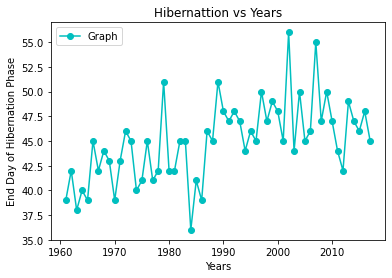

In [0]:
phi = 35.6667 #latitude converted into degree
L = 4 #(km)
total_yearsLen = len(training_years) + len(test_years)

years = [y for y in range(1961,2018)]

TF = [] #location's average temperature [°C]
D = [] #hibernation

#hibernation end Dj
for i in range(total_yearsLen):
  y = data_tokyo_Sakura[data_tokyo_Sakura.year.isin([years[i]])]
  m3Days = 90
  if(years[i]%4==0 and years[i]%100!=0) or years[i]%400==0:
       m3Days = m3Days + 1 #taking_leapYears
  accuAvgTemp = 0
  for j in range(m3Days):
    accuAvgTemp = accuAvgTemp + y.values[j][9]
  temp_Avg = accuAvgTemp/m3Days #average temp. for first 3 month of a year
  TF = TF + [temp_Avg]
  D = D + [int(round(136.75-7.689*phi+0.133*phi*phi-1.307*math.log(L)+0.144*TF[i]+0.285*TF[i]*TF[i]))]

df = {'All Years':years,'Dj':D}
df = pd.DataFrame(data=df)
df = df[['All Years','Dj']]
print('\n',df)

# Plotting
plt.figure(3)
plt.plot(years,D,'-co',label="Graph")
plt.xlabel("Years")
plt.ylabel("End Day of Hibernation Phase")
plt.title("Hibernattion vs Years")
plt.legend()
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


DTSmean by activation energy : [15.083]
    Ea    DTSmean
0    5  31.890255
1    6  30.190354
2    7  28.593657
3    8  27.093416
4    9  25.683346
5   10  24.357597
6   11  23.110720
7   12  21.937638
8   13  20.833621
9   14  19.794260
10  15  18.815443
11  16  17.893339
12  17  17.024372
13  18  16.205204
14  19  15.432724
15  20  14.704026
16  21  14.016395
17  22  13.367298
18  23  12.754368
19  24  12.175392
20  25  11.628304
21  26  11.111169
22  27  10.622182
23  28  10.159650
24  29   9.721993
25  30   9.307731
26  31   8.915477
27  32   8.543934
28  33   8.191887
29  34   7.858198
30  35   7.541799
31  36   7.241692
32  37   6.956939
33  38   6.686661
34  39   6.430032
35  40   6.186280


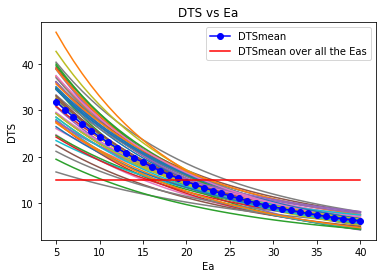

In [0]:
#Given data
R = 8.314 #J/(K.mol)
Ts = 273+17 #Standard temperature
c = 4184 # KCal to Joule

#standard reaction time
def std_reactn_time(Ea,Tij,Ts,R):
  ts = math.exp((Ea*(Tij-Ts))/(R*Tij*Ts)) #std reaction time according to the given equation
  return ts

#test & train data
test_D = []
for i in range(len(test_years)):
    y = years.index(test_years[i])
    test_D = test_D + [D[y]]

train_D = []
for i in range(len(training_years)):
    y = years.index(training_years[i])
    train_D = train_D + [D[y]]

#taking Ea for given range up to 40
Ea=[i for i in range(5,41)]

#Transformed Temperature days
DTSj = []
for i in range(len(training_years)):
    y = training_data[training_data.year.isin([training_years[i]])]
    df1 = datetime.date(training_BD.values[i][0],training_BD.values[i][1],training_BD.values[i][2])
    df2 = datetime.date(training_BD.values[i][0],1,1)
    #including January 1
    df = (df1-df2).days+1  
    DTS = []
    for e in Ea:
      TS = []
      for j in range(train_D[i] - 1,df):
        ts = std_reactn_time(e*c,y.values[j][9]+273,Ts,R)
        TS = TS + [ts]
      DTS = DTS + [sum(TS)]
    DTSj = DTSj + [DTS]

#finding out DTSmean
DTSmean = []
DTSmean_all = []
for i in range(len(Ea)):
    DTS_sum = 0
    for j in range(len(training_years)):
        DTS_sum = DTS_sum + DTSj[j][i]
    DTSmean = DTSmean + [DTS_sum/(len(training_years))]
DTSmean_actE = [round(sum(DTSmean)/len(Ea),3)]
print("DTSmean by activation energy :", DTSmean_actE)
DTS_m = [DTSmean_actE for i in range(len(Ea))]

df ={'Ea':Ea,'DTSmean':DTSmean}
df = pd.DataFrame(data=df)
df = df[['Ea','DTSmean']]
print(df)

#plotting
plt.figure(4)  
#for 52 years
l = len(training_years)
for i in range(l):
    plt.plot(Ea,DTSj[i]) 
    plt.xlabel("Ea")    
    plt.ylabel("DTS")                               
    plt.title("DTS vs Ea")
plt.plot(Ea, DTSmean,"-bo",label="DTSmean")
plt.plot(Ea,DTS_m,"r",label="DTSmean over all the Eas")
plt.legend()
plt.show()


### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

Prediction :
 [[[1961    3   24]
  [1961    3   24]
  [1961    3   25]
  ...
  [1961    4    2]
  [1961    4    2]
  [1961    4    2]]

 [[1962    3   25]
  [1962    3   26]
  [1962    3   26]
  ...
  [1962    4    2]
  [1962    4    2]
  [1962    4    2]]

 [[1963    3   24]
  [1963    3   24]
  [1963    3   25]
  ...
  [1963    4    1]
  [1963    4    1]
  [1963    4    1]]

 ...

 [[2015    3   28]
  [2015    3   28]
  [2015    3   27]
  ...
  [2015    3   27]
  [2015    3   27]
  [2015    3   27]]

 [[2016    3   28]
  [2016    3   28]
  [2016    3   28]
  ...
  [2016    3   21]
  [2016    3   20]
  [2016    3   20]]

 [[2017    3   27]
  [2017    3   27]
  [2017    3   27]
  ...
  [2017    3   31]
  [2017    3   31]
  [2017    3   31]]]
    Ea  MeanSqError
0    5    54.903846
1    6    50.384615
2    7    45.403846
3    8    40.307692
4    9    37.230769
5   10    33.461538
6   11    29.692308
7   12    26.538462
8   13    24.750000
9   14    22.000000
10  15    19.903846
11  16  

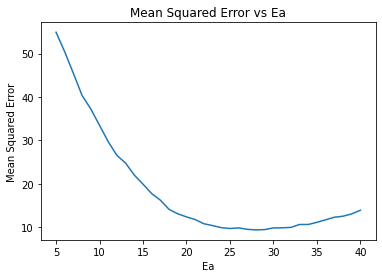

In [0]:
#accumulated Ts for every training_years and Ea
#year = []
#TS = []
#yr_accTs = []

pred_BD = [] #bloom date prediction

for i in range(l):
  y = training_data[training_data.year.isin([training_years[i]])]
  pred_date = []
  #year.append((y.values[i][1]).astype('int64')) 
  for j in range(len(Ea)):
    accumulated_ts = 0
    k = train_D[i] - 1
    # ts = (std_reactn_time(Ea[j]*c,y.values[k][9]+273,Ts,R))
    # TS = TS + [ts]
    while accumulated_ts < DTSmean[j]:
      try:
        accumulated_ts = accumulated_ts + std_reactn_time(Ea[j]*c,y.values[k][9]+273,Ts,R)
        k = k + 1
      except:
        break 
        #to break when accumulated Ts reaches DTSmean and aslo it may not exceed 2017yr
    k = k - 1
    p_date = [y.values[k][1],y.values[k][2],y.values[k][3]]
    #print(p_date)
    pred_date = pred_date + [p_date]
    #print(pred_date)
  pred_BD = pred_BD + [pred_date]
#print(pred_BD)
# #Bloom date for each Ea [created npArray due to length missmatch -> 52X36X3]
pred_BD = np.asarray(pred_BD,dtype=int)
#print(pred_BD)
# # accTs_df = pd.DataFrame({"year": year})

# #Mean Squared Error
mean_sq_err = []

for i in range(len(Ea)):
  sum_err = 0
  for j in range(l):
    d1 = datetime.date(training_BD.values[j][0],training_BD.values[j][1],training_BD.values[j][2])
    d2 = datetime.date(pred_BD[j][i][0].astype('int64'),pred_BD[j][i][1].astype('int64'),pred_BD[j][i][2].astype('int64'))
    #d2 = datetime.date(pred_BD[j][i][0],pred_BD[j][i][1],pred_BD[j][i][2])
    d = abs(d1-d2).days #substracting prediction days from bloom days to find error
    sum_err = sum_err + d**2
  mean_sq_err = mean_sq_err + [(sum_err/l)]
#print(mean_sq_err)
#minimum value would be the Optimal Ea
opt_Ea = Ea[mean_sq_err.index(min(mean_sq_err))]
print("Prediction :\n",pred_BD)
df = pd.DataFrame({'Ea':Ea,'MeanSqError':mean_sq_err})
df = df[['Ea','MeanSqError']]
print(df)
print("Optimal Ea : ",opt_Ea)

plt.figure(5)
plt.plot(Ea,mean_sq_err)
plt.xlabel("Ea")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs Ea")
plt.show()



### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [0]:
#DTSmean for optimal Ea
DTSmean_opt = DTSmean[Ea.index(opt_Ea)]

#prediction for TEST years using optimal Ea
pred_blmD = []
tst_l = len(test_years)
for i in range(tst_l):
  y = tested_data[tested_data.year.isin([test_years[i]])]
  accumulated_ts = 0
  k = train_D[i] - 1
  while accumulated_ts < DTSmean_opt:
    accumulated_ts = accumulated_ts + std_reactn_time(opt_Ea*c,y.values[k][9]+273,Ts,R)
    k = k + 1
  k = k - 1
  p_date = [y.values[k][1],y.values[k][2],y.values[k][3]]
  #print(p_date)
  pred_blmD = pred_blmD + [p_date]
pred_blmD = np.asarray(pred_blmD,dtype=int)

#error
optEa_err = []
for i in range(tst_l):
  d1 = datetime.date(pred_blmD[i][0],pred_blmD[i][1],pred_blmD[i][2])
  d2 = datetime.date(tested_BD.values[i][0],tested_BD.values[i][1],tested_BD.values[i][2])
  d = abs(d1-d2).days
  optEa_err = optEa_err + [d]

#predicted days
pred_daysEa = []
for i in range(5):
    d1 = datetime.date(pred_blmD[i][0],pred_blmD[i][1],pred_blmD[i][2])
    d2 = datetime.date(tested_BD.values[i][0],1,1)
    pred_D = abs(d1-d2).days+1
    pred_daysEa = pred_daysEa + [pred_D]

#Using SKlearn
R2_Optimal_Ea = mc.r2_score(Actual_Days,pred_daysEa) # Actual_Days from problem 1-2

print('-------------Actual Bloom Dates-------------\n',tested_BD)
print('-------------Prediction using Optimal Ea-------------\n',pred_blmD)
print("---------------------------------------")
df = pd.DataFrame({'Test Years':test_years,'Error in Days':optEa_err})
df = df[['Test Years','Error in Days']]
print(df)
R2_Optimal_Ea = float("{:.3f}".format(R2_Optimal_Ea))
print("-------------R2 Score-------------\n",R2_Optimal_Ea)


-------------Actual Bloom Dates-------------
    year  month  day
0  1966      3   20
1  1971      3   30
2  1985      4    3
3  1994      3   31
4  2008      3   22
-------------Prediction using Optimal Ea-------------
 [[1966    3   16]
 [1971    3   29]
 [1985    3   30]
 [1994    3   31]
 [2008    3   20]]
---------------------------------------
   Test Years  Error in Days
0        1966              4
1        1971              1
2        1985              4
3        1994              0
4        2008              2
-------------R2 Score-------------
 0.73


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

In [0]:
#Discussion
#(1)Other features like sea pressure,sun hours etc. could be taken into account to tune the performance better of the model rather than only 
#taking Max Temperature as feature.

#(2)It can't be said to a exact level that how much accuracy could be achieved without experimenting with other features but assumption is, 
#it can be achieved upto 90%.Since realtime scenario of sakura blooming not depend on only Temperature.

#(3)Due to temperature fluctuation we can't expect contant output. Hence,equations can be improved a bit since we know that output of 
#ideal equation never match(most of the cases)with experimental situation.

#(4)For better performance real time activation energy Ea could be measured.

#(5)Equation given by Hayashi(2012) for determining end of Hibernation can be improved by considering inconsistency of real time world, 
#since the given equation is just an approximation.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [0]:
import warnings

#Neural Network Model
NNm = data_tokyo_Sakura

#since all the bloom dates are seemed to happen within first 4 months of a year
NNm = NNm[NNm.month <= 3]
column_list = list(NNm)
column_list = column_list[4 : 15]
# print(column_list)
unwanted_list = ['serial','year','month','day','bloom']
Yrs =[1961,1963,1964,1965,1969,1970,1972,1973,1981,1982,1983,1984,1986,1987, \
   1991,1992,1993,1995,1996,2004,2005,2006,2007,2009,2010]
Yrs_idx = [training_years.index(Yrs[i]) for i in range(len(Yrs))]
#print(Yrs_idx)

#Train set
Xtrn = []
Ytrn = []
for i in range(len(Yrs_idx)):
  y = NNm[NNm.year.isin([training_years[Yrs_idx[i]]])]
  y = y.drop(unwanted_list,1)
  y = y.sum()
  Xtrn = Xtrn + [y]
  d1 =  datetime.date(training_BD.values[Yrs_idx[i]][0],training_BD.values[Yrs_idx[i]][1],training_BD.values[Yrs_idx[i]][2])
  d2 =  datetime.date(training_BD.values[Yrs_idx[i]][0],1,1)
  d = (d1 - d2).days + 1
  Ytrn = Ytrn + [d] 


#Test Set
Xtst = []
Ytst = []
for i in range(5):
    y = NNm[NNm.year.isin([test_years[i]])]
    y = y.drop(unwanted_list,1)
    y = y.sum()
    Xtst = Xtst + [y]
    d1 = datetime.date(tested_BD.values[i][0],tested_BD.values[i][1],tested_BD.values[i][2])
    d2 = datetime.date(tested_BD.values[i][0],1,1)
    d = (d1 - d2).days + 1
    Ytst = Ytst + [d]

#layers
hidden_layers = [10 for i in range(21)]
hidden_layers = tuple(hidden_layers)

# print("Xtrn\n",Xtrn)
# print("Ytrn\n",Ytrn)


#Neural Network
# run block of code and catch warnings
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
	# ignore all caught warnings
  rgr = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=hidden_layers,activation='identity',solver="lbfgs",max_iter=172,alpha=20,learning_rate='invscaling',random_state=10,early_stopping=True)
  rgr = rgr.fit(Xtrn,Ytrn)

pred_by_NN = []
pred_days_NN = rgr.predict(Xtst)
# print(pred_days_NN)
# print(Xtst)
pred_days_NN = [int(pred_days_NN[i]) for i in range(5)]
# print(pred_days_NN)
for i in range(5):
    y = tested_data[tested_data.year.isin([test_years[i]])]
    # print(y)
    r = pred_days_NN[i] - 1
    d = [y.values[r][1],y.values[r][2],y.values[r][3]]
    pred_by_NN = pred_by_NN + [d]

pred_by_NN = np.asarray(pred_by_NN,dtype=int) # predicted bloom dates
Rsqr_NN = round(rgr.score(Xtst,Ytst),2) #Score (Accuracy) -> R2

print("-------------Actual Bloom Dates-------------\n",tested_BD)
print("-------------Prediction using Neural Network-------------\n",pred_by_NN)
print("R-Square Score(Accuracy) : ",Rsqr_NN)

-------------Actual Bloom Dates-------------
    year  month  day
0  1966      3   20
1  1971      3   30
2  1985      4    3
3  1994      3   31
4  2008      3   22
-------------Prediction using Neural Network-------------
 [[1966    3   19]
 [1971    4    1]
 [1985    4    4]
 [1994    3   29]
 [2008    3   23]]
R-Square Score(Accuracy) :  0.92


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

----------------R2 score of the three models are----------------
R-Square Score of 600 Rule :  0.679
R-Square Score of DTS method :  0.73
R-Square Score of Neural Network :  0.92
----------------Comparison between models----------------
Neural Network approach gives more accuracy than other applied two given models because it(NN) 
takes into account many features and requires parameters tuning. On the other hand 600 Rule perform least because 
the rule is based on only one feature,i.e Maximum Temperature whereas DTS method tries to give a real time 
flavour of calculation by taking into account not only Temperature but also Hibernation phase, Standard Reaction Time etc.
----------------Discussion----------------
Since Neural Network(NN) uses more features than other models, it shows greater accuracy and one exception at 90 days in this(NN)model.
For other models, Bloom dates seemed to delaying year by year.
----------------Ploting predicted dates VS actural date (difference of days fro

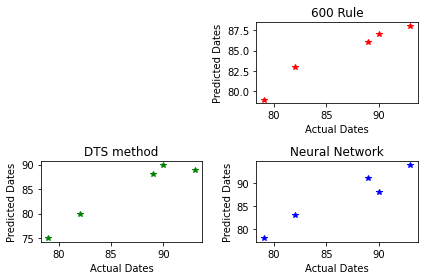

In [0]:
print("----------------R2 score of the three models are----------------")
print("R-Square Score of 600 Rule : ",R2600)
print("R-Square Score of DTS method : ",R2_Optimal_Ea)
print("R-Square Score of Neural Network : ",Rsqr_NN)
#Comparison
print("----------------Comparison between models----------------")
print('''Neural Network approach gives more accuracy than other applied two given models because it(NN) 
takes into account many features and requires parameters tuning. On the other hand 600 Rule perform least because 
the rule is based on only one feature,i.e Maximum Temperature whereas DTS method tries to give a real time 
flavour of calculation by taking into account not only Temperature but also Hibernation phase, Standard Reaction Time etc.''')

print("----------------Discussion----------------")
print('''Since Neural Network(NN) uses more features than other models, it shows greater accuracy and one exception at 90 days in this(NN)model.
For other models, Bloom dates seemed to delaying year by year.''')

#Plotting
print("----------------Ploting predicted dates VS actural date (difference of days from January 1)----------------")
plt.figure(6)
plt.subplot(2,2,2)
plt.plot(Actual_Days,PreDays600,"r*")
plt.xlabel("Actual Dates")
plt.ylabel("Predicted Dates")
plt.title("600 Rule")
plt.subplot(2,2,3)
plt.plot(Actual_Days,pred_daysEa,"g*")
plt.xlabel("Actual Dates")
plt.ylabel("Predicted Dates")
plt.title("DTS method")
plt.subplot(2,2,4)
plt.plot(Actual_Days,pred_days_NN,"b*")
plt.xlabel("Actual Dates")
plt.ylabel("Predicted Dates")
plt.title("Neural Network")
plt.tight_layout()
plt.show()


***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

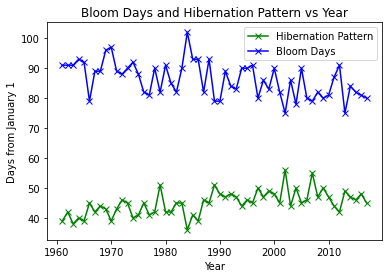

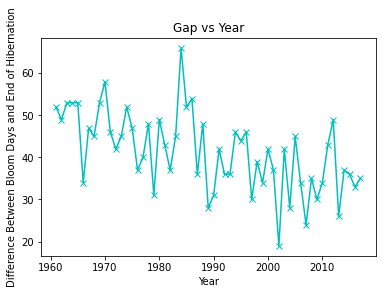

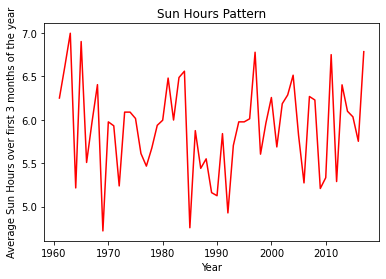

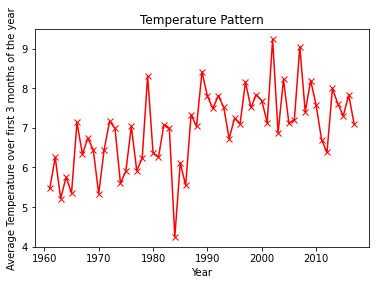

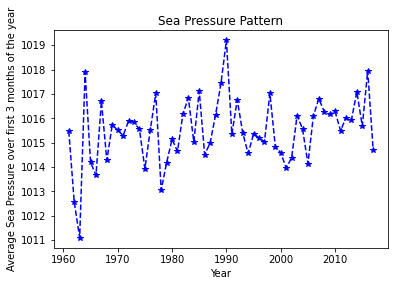

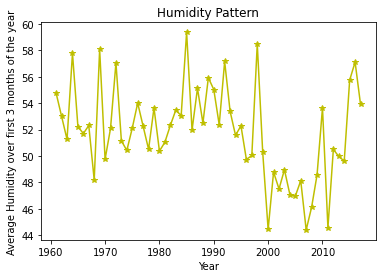

From the Graphs,(1)over the past 60 years changes in hibernation pattern is seen which can be verified by the graph of 1-1.
And Accumulated Max Temperature seemed decreasing year by year. 
(2)If temperature decreases Hibernation Period remains longer.
(3)Sea Pressure plays a role for sakura to bloom early in recent years. 
(4)But historical graph shows negative trend of gap which is inconsistent with the result of Neural Network model 
(5)If Temperature increases Humidity decreases which may effect the chemical reaction during hibernation period of Sakura


In [0]:
blm_days = []
gap = [] #gap days between bloom days and end of hibernation
temp_pattern = []
sea_prec = []
sun_hrs = []
avg_humid = []
  
for i in range(len(years)):

  d1 = datetime.date(data_BD.values[i][0],data_BD.values[i][1],data_BD.values[i][2])
  d2 = datetime.date(data_BD.values[i][0],1,1)
  d = (d1-d2).days + 1
  blm_days = blm_days + [d]

  gap = gap +[blm_days[i] - D[i]]
  y = data_tokyo_Sakura[data_tokyo_Sakura.year.isin([years[i]])]
  y = y[y.month <= 3]
  y = y['avg temp']
  y = y.mean()  
  temp_pattern = temp_pattern + [y]

  y = data_tokyo_Sakura[data_tokyo_Sakura.year.isin([years[i]])]
  y = y[y.month <= 3]
  y = y['sea pressure']
  y = y.mean()
  sea_prec = sea_prec + [y]

  y = data_tokyo_Sakura[data_tokyo_Sakura.year.isin([years[i]])]
  y = y[y.month <= 3]
  y = y['sun hours']
  y = y.mean()
  sun_hrs = sun_hrs + [y]
  
  y = data_tokyo_Sakura[data_tokyo_Sakura.year.isin([years[i]])]
  y = y[y.month <= 3]
  y = y['avg humid']
  y = y.mean()
  avg_humid = avg_humid + [y]

#Visualizing for investigation

plt.figure(7)
plt.plot(years,D,'-gx',label='Hibernation Pattern')
plt.plot(years,blm_days,'-bx',label='Bloom Days')
plt.xlabel('Year')
plt.ylabel('Days from January 1')
plt.title('Bloom Days and Hibernation Pattern vs Year')
plt.legend()

plt.figure(8)
plt.plot(years,gap,'-cx')
plt.xlabel('Year')
plt.ylabel('Difference Between Bloom Days and End of Hibernation')
plt.title('Gap vs Year')

plt.figure(9)
plt.plot(years,sun_hrs,'-r')
plt.xlabel('Year')
plt.ylabel('Average Sun Hours over first 3 months of the year')
plt.title('Sun Hours Pattern')

plt.figure(10)
plt.plot(years,temp_pattern,'-rx')
plt.xlabel('Year')
plt.ylabel('Average Temperature over first 3 months of the year')
plt.title('Temperature Pattern')

plt.figure(11)
plt.plot(years,sea_prec,'--b*')
plt.xlabel('Year')
plt.ylabel('Average Sea Pressure over first 3 months of the year')
plt.title('Sea Pressure Pattern')

plt.figure(12)
plt.plot(years,avg_humid,'-y*')
plt.xlabel('Year')
plt.ylabel('Average Humidity over first 3 months of the year')
plt.title('Humidity Pattern')

plt.show()

#Discussion
print('''From the Graphs,

(1)over the past 60 years changes in hibernation pattern is seen which can be verified by the graph of 1-1.
And Accumulated Max Temperature seemed decreasing year by year. 
(2)If temperature decreases Hibernation Period remains longer.
(3)Sea Pressure plays a role for sakura to bloom early in recent years. 
(4)But historical graph shows negative trend of gap which is inconsistent with the result of Neural Network model 
(5)If Temperature increases Humidity decreases which may effect the chemical reaction during hibernation period of Sakura

''')


